# Assignment 2 - Building a Random Forest

This is a skeleton of a Random Forest classifier for the example data set in `data/example.csv`.

In [544]:
import csv
import math
from statistics import median, mode, mean
from collections import Counter
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [545]:
df_train = pd.read_csv("data/housing_price_train.csv")
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [546]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [547]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

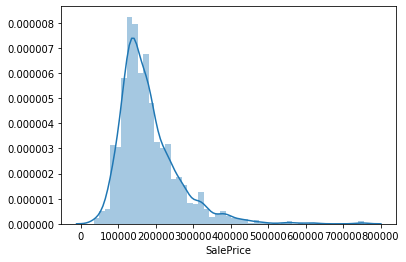

In [548]:
sns.distplot(df_train['SalePrice'])

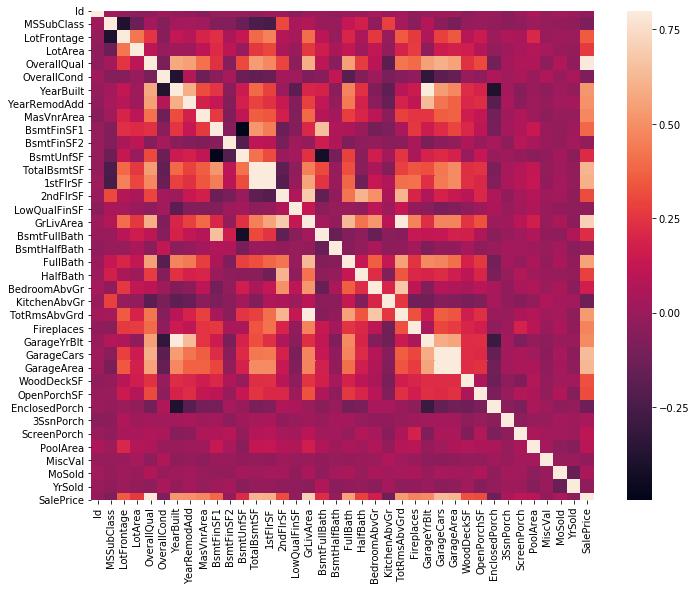

In [549]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [550]:
print(df_train.isnull())

         Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
0     False       False     False        False    False   False   True   
1     False       False     False        False    False   False   True   
2     False       False     False        False    False   False   True   
3     False       False     False        False    False   False   True   
4     False       False     False        False    False   False   True   
...     ...         ...       ...          ...      ...     ...    ...   
1455  False       False     False        False    False   False   True   
1456  False       False     False        False    False   False   True   
1457  False       False     False        False    False   False   True   
1458  False       False     False        False    False   False   True   
1459  False       False     False        False    False   False   True   

      LotShape  LandContour  Utilities  ...  PoolArea  PoolQC  Fence  \
0        False        False      False 

In [551]:
null_counts = df_train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

Some simple type definitions.

In [552]:
class AttrType(Enum):
    cat = 0  # categorical (qualitative) attribute
    num = 1  # numerical (quantitative) attribute
    target = 2  # target label
    index = 3


class NodeType(Enum):
    root = 0
    internal = 1
    leaf = 2


class SplitType(Enum):
    bin = 0  # binary split
    multi = 1  # multi-way split

Also, some basic classes to represent an attribute, a spltting procedure, and a node.

In [553]:
class Attribute(object):
    def __init__(self, label, type):
        assert type in AttrType
        self.label = label
        self.type = type
        self.stat = None  # holds mean for numerical and mode for categorical attributes


class Splitting(object):
    def __init__(self, attr, infogain, split_type, cond, splits):
        self.attr = attr  # attribute ID (index in ATTR)
        self.infogain = infogain  # information gain if splitting is done on this attribute
        self.split_type = split_type  # one of SplitType
        self.cond = cond  # splitting condition, i.e., values on outgoing edges
        self.splits = splits  # list of training records (IDs) for each slitting condition


class Node(object):
    def __init__(self, id, type, parent_id, children=None, edge_value=None, val=None, split_type=None, split_cond=None,
                 infogain=None):
        self.id = id  # ID (same as the index in DT.model list)
        self.type = type  # one of NodeType
        self.parent_id = parent_id  # ID of parent node (None if root)
        self.children = children  # list of IDs of child nodes
        self.edge_value = edge_value  # the value of the incoming edge (only if not root node)
        self.val = val  # if root or internal node: the attribute that is compared at that node; if leaf node: the target value
        self.split_type = split_type  # one of SplitType
        self.split_cond = split_cond  # splitting condition (median value for binary splits on numerical values; otherwise a list of categorical values (corresponding to child nodes))
        self.infogain = infogain

    def append_child(self, node_id):
        self.children.append(node_id)

The input filename is hard-coded.

In [554]:
len(df_train)

1460

In [555]:
#Import the dataset and define the feature as well as the target datasets / columns#
df_train = pd.read_csv('data/housing_price_train.csv')        
df_train.dropna(inplace=True,thresh=(0.7*len(df_train)),axis=1,how='any')
df_train = df_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
le = preprocessing.LabelEncoder()
columns=df_train.columns[list(range(len(df_train.columns)-1))]
df_train[columns] = df_train[columns].apply(lambda col: le.fit_transform(col))
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,5,3,36,327,1,3,3,0,4,...,0,0,0,0,0,1,2,8,4,208500
1,1,0,3,51,498,1,3,3,0,2,...,0,0,0,0,0,4,1,8,4,181500
2,2,5,3,39,702,1,0,3,0,4,...,0,0,0,0,0,8,2,8,4,223500
3,3,6,3,31,489,1,0,3,0,0,...,108,0,0,0,0,1,0,8,0,140000
4,4,5,3,55,925,1,0,3,0,2,...,0,0,0,0,0,11,2,8,4,250000


In [556]:
df_test = pd.read_csv('data/housing_price_test.csv')
df_test = df_test.drop(["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","LotFrontage","GarageCond","GarageQual","GarageFinish","GarageYrBlt","GarageType","BsmtFinType2","BsmtExposure","BsmtFinType1","BsmtCond","BsmtQual","MasVnrArea","MasVnrType"],axis=1)
null_counts = df_test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

MSZoning        4
Functional      2
BsmtHalfBath    2
BsmtFullBath    2
Utilities       2
SaleType        1
GarageArea      1
GarageCars      1
KitchenQual     1
TotalBsmtSF     1
BsmtUnfSF       1
BsmtFinSF2      1
BsmtFinSF1      1
Exterior2nd     1
Exterior1st     1
dtype: int64

In [557]:
df_test = df_test.drop(df_test.loc[df_test['MSZoning'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['BsmtHalfBath'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['BsmtFullBath'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['SaleType'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['GarageArea'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['GarageCars'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['Functional'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['KitchenQual'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['TotalBsmtSF'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['BsmtUnfSF'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['TotalBsmtSF'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['BsmtFinSF2'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['BsmtFinSF1'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['Exterior2nd'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['Exterior1st'].isnull()].index)
df_test = df_test.drop(df_test.loc[df_test['Utilities'].isnull()].index)
le = preprocessing.LabelEncoder()
columns=df_test.columns[list(range(len(df_test.columns)))]
df_test[columns] = df_test[columns].apply(lambda col: le.fit_transform(col))
df_test.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,0,3,826,1,3,3,0,4,0,...,0,0,0,17,0,0,5,4,8,4
1,1,0,4,1023,1,0,3,0,0,0,...,24,0,0,0,0,24,5,4,8,4
2,2,5,4,1003,1,0,3,0,4,0,...,22,0,0,0,0,0,2,4,8,4
3,3,5,4,626,1,0,3,0,4,0,...,24,0,0,0,0,0,5,4,8,4
4,4,11,4,126,1,0,1,0,4,0,...,68,0,0,26,0,0,0,4,8,4


In [558]:
#ATTR = [Attribute("Outlook", AttrType.cat), Attribute("Temperature", AttrType.num),
#        Attribute("Humidity", AttrType.num), Attribute("Windy", AttrType.cat), Attribute("Play?", AttrType.target)]
#Y'a peut etre moyen de faire une boucle, avec .append et si cest un int ou un tring ;append différent
#ATTR = [Attribute('Id',AttrType.num), Attribute('MSSubClass',AttrType.num), Attribute('MSZoning',AttrType.cat), Attribute('LotFrontage',AttrType.num), Attribute('LotArea',AttrType.num), Attribute('Street',AttrType.cat),
#        Attribute('Alley',AttrType.cat), Attribute('LotShape',AttrType.cat), Attribute('LandContour',AttrType.cat), Attribute('Utilities',AttrType.cat), Attribute('LotConfig',AttrType.cat),
#        Attribute('LandSlope',AttrType.cat), Attribute('Neighborhood',AttrType.cat), Attribute('Condition1',AttrType.cat), Attribute('Condition2',AttrType.cat), Attribute('BldgType',AttrType.cat),
#        Attribute('HouseStyle',AttrType.cat), Attribute('OverallQual',AttrType.num), Attribute('OverallCond',AttrType.num), Attribute('YearBuilt',AttrType.num), Attribute('YearRemodAdd',AttrType.num),
#        Attribute('RoofStyle',AttrType.cat), Attribute('RoofMatl',AttrType.cat), Attribute('Exterior1st',AttrType.cat), Attribute('Exterior2nd',AttrType.cat), Attribute('MasVnrType',AttrType.cat),
#        Attribute('MasVnrArea',AttrType.num), Attribute('ExterQual',AttrType.cat), Attribute('ExterCond',AttrType.cat), Attribute('Foundation',AttrType.cat), Attribute('BsmtQual',AttrType.cat),
#        Attribute('BsmtCond',AttrType.cat), Attribute('BsmtExposure',AttrType.cat), Attribute('BsmtFinType1',AttrType.cat), Attribute('BsmtFinSF1',AttrType.num),
#        Attribute('BsmtFinType2',AttrType.cat), Attribute('BsmtFinSF2',AttrType.num), Attribute('BsmtUnfSF',AttrType.num), Attribute('TotalBsmtSF',AttrType.num), Attribute('Heating',AttrType.cat),
#        Attribute('HeatingQC',AttrType.cat), Attribute('CentralAir',AttrType.cat), Attribute('Electrical',AttrType.cat), Attribute('1stFlrSF',AttrType.num), Attribute('2ndFlrSF',AttrType.num),
#        Attribute('LowQualFinSF',AttrType.num), Attribute('GrLivArea',AttrType.num), Attribute('BsmtFullBath',AttrType.num), Attribute('BsmtHalfBath',AttrType.num), Attribute('FullBath',AttrType.num),
#        Attribute('HalfBath',AttrType.num), Attribute('BedroomAbvGr',AttrType.num), Attribute('KitchenAbvGr',AttrType.num), Attribute('KitchenQual',AttrType.cat),
#        Attribute('TotRmsAbvGrd',AttrType.num), Attribute('Functional',AttrType.cat), Attribute('Fireplaces',AttrType.num), Attribute('FireplaceQu',AttrType.cat), Attribute('GarageType',AttrType.cat),
#        Attribute('GarageYrBlt',AttrType.num), Attribute('GarageFinish',AttrType.cat), Attribute('GarageCars',AttrType.num), Attribute('GarageArea',AttrType.num), Attribute('GarageQual',AttrType.cat),
#        Attribute('GarageCond',AttrType.cat), Attribute('PavedDrive',AttrType.cat), Attribute('WoodDeckSF',AttrType.num), Attribute('OpenPorchSF',AttrType.num),
#        Attribute('EnclosedPorch',AttrType.num), Attribute('3SsnPorch',AttrType.num), Attribute('ScreenPorch',AttrType.num), Attribute('PoolArea',AttrType.num), Attribute('PoolQC',AttrType.cat),
#        Attribute('Fence',AttrType.cat), Attribute('MiscFeature',AttrType.cat), Attribute('MiscVal',AttrType.num), Attribute('MoSold',AttrType.num), Attribute('YrSold',AttrType.num), Attribute('SaleType',AttrType.cat),
#        Attribute('SaleCondition',AttrType.cat), Attribute('SalePrice', AttrType.target)]

The attribute labels types are hard-coded too (the same order as in the file!).

In [559]:
ATTR=[]
for attr in columns:
    ATTR.append(Attribute(attr, AttrType.num))
IDX_TARGET = len(ATTR)-1    
ATTR.append(Attribute('SalePrice', AttrType.target))   

The index of the target attribute (assuming it's the last).

In [560]:
IDX_TARGET 

61

In [561]:
INFILE = "data/housing_price_train.csv"

In [562]:
def split_categorical(records, attr_name, values_sets):
    """Splits a list of records by a given categorical attribute, using a partition of possible values.
    
    :param records: a list of records to split.
    :param attr_name: the name of the categorical attribute.
    :param values_sets: a partition list of sets A_i. Given the m possible values Vals(D) = {dj | j=1, ..., m} of the \
    attribute D, each A_i is a subset of possible values, such that all the A_i sets make a partition (mutually \
    disjoint, and the union of all is Vals(D)).
    :return: a list of lists, each of these ones contains all the records associated with one of the children.
    """
    print("Splitting by {}".format(attr_name))
    children = []
    attribute = 0
    for i in range(len(ATTR)):
        if(ATTR[i].label == attr_name):
            attribute = i-1
    for a_i in values_sets:  # for each subset of possible values
        child = [x for x in records if x[attribute] in a_i]  # 
        children.append(child)        
        # We also print the entropy for each child
        print("\tChild condition: {}\tSize = {}".format(a_i, len(child)))
    return children

In [563]:
def split_numeric_binary(records, attr_name):
    """Splits in a binary way -i.e., using a single splitting point- a list of records by a given numeric attribute.

    :param records: a list of records to split.
    :param attr_name: the name of the numeric attribute.
    :return: a list of lists, each list contains all the records associated with one child.
    """

    #spliting point can't be the same for every node (nonsense)
    print("Splitting by {}".format(attr_name))
    attribute = 0
    for i in range(1,len(ATTR)):
        if(ATTR[i].label == attr_name):
            attribute = i-1
    total = 0
    for i in range(len(data)):
        total += data[i][attribute]
    splitting_point = total / len(data)
      
    children = [[x for x in records if x <= splitting_point],
               [x for x in records if x > splitting_point]]
    
    # We also print the entropy for each child
    a=weightVariance(children,len(data))
    print("\t'Less-or-equal-than' child. Size = {}\tWeight Variance = {}".format(len(children[0]), a[0]))
    print("\t'Greater-than' child. Size = {}\tWeight Variance = {}".format(len(children[1]), a[1]))

    return children

In [564]:
#Test split categorical
#children_cat = split_categorical(data, "MSZoning", df_train.MSZoning.unique())

In [565]:
#test split binary
#children_bin = split_numeric_binary(data, "MSSubClass")

In [566]:
def weightVariance(records,n):
    weightVar=np.zeros(len(records))
    index_target=len(records)-1
    somme=0
    for i in range(len(records)):
        somme += (int)(records[i][IDX_TARGET])
    weightVar[i]=(len(records[i])/n)*(((int)(records[i][IDX_TARGET])-somme/len(records[i]))**2)
    return weightVar

A class DT representing the decision tree classifier. It could represent with methods:

  - a given impurity measure;
  - the search for the best attribute to split with;
  - the addition of a node to the tree;
  - a convenient model printer;
  - the recursive call for obtaining a tree;
  - a builder and an applier.

In [567]:
class DT(object):
    def __init__(self):
        self.data = None  # training data set (loaded into memory)
        self.model = None  # decision tree model
        self.default_target = 0.0  # default target class
     
    #becomes useless since I do some preprocessing on data
    def __load_data(self):
        with open(INFILE) as csvfile:
            self.data = []
            csvreader = csv.reader(csvfile, delimiter=',')
            firstRow = True
            for row in csvreader:
                if firstRow == True:
                    firstRow = False
                    continue
                rec = []
                for i in range(1,len(ATTR)):
                    val = row[i].strip()
                    # convert numerical attributes
                    if ATTR[i].type == AttrType.num:  # Note that this will break for "?" (missing attribute)
                        val = float(val)
                    rec.append(val)
                self.data.append(rec)
                # self.data.append([element.strip() for element in row])  # strip spaces
        
    
    def __mean_squared_error(self, records):
        """
        Calculates mean squared error for a selection of records.

        :param records: Data records (given by indices)
        """
        if len(records)==0:
            return 0

        mn=mean(self.data[records][:,IDX_TARGET].astype(float))
        diff=[i-mn for i in self.data[records][:,IDX_TARGET].astype(float)]
        MSE = np.square(diff).mean()        
        return MSE
    
    
    def __median(self,a):       
        return np.mean((self.data[:,a]))
    
        
    def __find_best_attr(self, attrs, records):
        """
        Finds the attribute with the largest gain.

        :param attrs: Set of attributes
        :param records: Training set (list of record ids)
        :return:
        """
        mse_p = self.__mean_squared_error(records)  # parent's MSE
        #mse_p = weightVariance(records,len(records))
        splittings = []  # holds the splitting information for each attribute
        
        for a in attrs:
            assert ATTR[a].type in AttrType
            splits = {}  # record IDs corresponding to each split
            # splitting condition depends on the attribute type
            
            if ATTR[a].type == AttrType.target:  # skip target attribute                
                continue         
            elif ATTR[a].type == AttrType.num:  # numerical attribute => binary split on median value
                split_mode = SplitType.bin
                split_cond = self.__median(a)  # (i.e., if less or equal than this value)
                # TODO collect training records for each split (in `splits`)
                training_records_Left=[]
                training_records_Right=[]
                for idx in records:
                    if self.data[idx][a]<= split_cond:                        
                        training_records_Left.append(idx)
                    else:
                        training_records_Right.append(idx)
                splits['Left']=training_records_Left 
                splits['Right']=training_records_Right
                gain_children=len(training_records_Left)*self.__mean_squared_error(training_records_Left)+len(training_records_Right)*self.__mean_squared_error(training_records_Right)
            # TODO compute gain for attribute a
    
            infogain=len(records)*mse_p-gain_children           
            splitting = Splitting(a, infogain, split_mode, split_cond, splits)
            splittings.append(splitting)

        # find best splitting
        best_splitting = sorted(splittings, key=lambda x: x.infogain, reverse=True)[0]
        return best_splitting

    def __add_node(self, parent_id, node_type=NodeType.internal, edge_value=None, val=None, split_type=None,
                   split_cond=None):
        """
        Adds a node to the decision tree.

        :param parent_id:
        :param node_type:
        :param edge_value:
        :param val:
        :param split_type:
        :param split_cond:
        :return:
        """
        node_id = len(self.model)  # id of the newly assigned node
        if not self.model:  # the tree is empty
            node_type = NodeType.root

        node = Node(node_id, node_type, parent_id, children=[], edge_value=edge_value, val=val, split_type=split_type,
                    split_cond=split_cond)
        self.model.append(node)

        # also add it as a child of the parent node
        if parent_id is not None:
            self.model[parent_id].append_child(node_id)

        return node_id
    
    def __id3(self, attrs, records, parent_id=None, value=None):
        """
        Function ID3 that returns a decision tree.

        :param attrs: Set of attributes
        :param records: Training set (list of record ids)
        :param parent_id: ID of parent node
        :param value: Value corresponding to the parent attribute, i.e., label of the edge on which we arrived to this node
        :return:
        """
        # empty training set or empty set of attributes => create leaf node with default class
        if len(records)<5 or not attrs:
            default_class = mean(self.data[records][:,IDX_TARGET])
            self.__add_node(parent_id, node_type=NodeType.leaf, edge_value=value, val=default_class)
            return

        # if all records have the same target value => create leaf node with that target value
        same = all(self.data[idx][IDX_TARGET] == self.data[records[0]][IDX_TARGET] for idx in records)
        if same:
            target = self.data[records[0]][IDX_TARGET]
            self.__add_node(parent_id, node_type=NodeType.leaf, edge_value=value, val=target)
            return

        # find the attribute with the largest gain
        splitting = self.__find_best_attr(attrs, records)        
        # add node
        node_id = self.__add_node(parent_id, edge_value=value, val=splitting.attr, split_type=splitting.split_type,
                                  split_cond=splitting.cond)
        # TODO call tree construction recursively for each split  
        attrs = [i for i in attrs if i != splitting.attr]
        for next_val,next_rec  in splitting.splits.items():
            self.__id3(attrs, next_rec,node_id, next_val)
           

    def print_model(self, node_id=0, level=0):
        node = self.model[node_id]
        indent = "  " * level
        if node.type == NodeType.leaf:
            print(indent + str(node.edge_value) + " [Leaf node] class=" + str(node.val))
        else:
            cond = " <= " + str(node.split_cond) if ATTR[node.val].type == AttrType.num else " == ? "
            if node.type == NodeType.root:
                print("[Root node] '" + ATTR[node.val].label + "'" + cond)
            else:
                print(indent + str(node.edge_value) + " [Internal node] '" + ATTR[node.val].label + "'" + cond)
            # print tree for child notes recursively
            for n_id in node.children:
                self.print_model(n_id, level + 1)

    def build_model(self,data):
        self.data = data
        self.model = []  # holds the decision tree model, represented as a list of nodes
        # Get majority class
        #   Note: Counter returns a dictionary, most_common(x) returns a list with the x most common elements as
        #         (key, count) tuples; we need to take the first element of the list and the first element of the tuple
        
        self.default_target = mean( [ float(x[IDX_TARGET]) for x in self.data])        
        self.__id3(set(range(len(ATTR))), list(range(len(self.data))))
        self.print_model()
        
        
    def apply_model(self, record):  
        node = self.model[0]
        # TODO based on the value of the record's attribute that is tested in `node`,
        # set `node` to one of its child nodes until a leaf node is reached        
        while node.type != NodeType.leaf:
            next_index = 0 
            if (record[node.val] < node.split_cond):
                next_index=1
            node = self.model[node.children[next_index]]    
        return node.val
    
    def predict(self, records):
        predictions = []
        for record in records:
            pred_val = self.apply_model(record)
            predictions.append(pred_val)
        return predictions


In [568]:
records_train = df_train.to_numpy()
records_test = df_test.to_numpy()

In [569]:
test_ids=df_test['Id']

In [570]:
def createSubmission(test_ids, predictions):
    sub = pd.DataFrame()
    sub['Id'] = test_ids
    sub['SalePrice'] = predictions
    sub.to_csv('submission.csv',index=False)

A class RF representing the random forest classifier. It could represent with methods:

  - subsampling from the dataset
  - build a model with multiple decision trees
  - apply the model

In [571]:
class RF(object):
    def __init__(self):
        self.data = None  # training data set (loaded into memory)
        self.trees = None  # decision trees
        
    def __load_data(self):
        # TODO
        a=4
        
    def __subsampling(self, train_set, sample_size_ratio):
        sample_number = round(len(self.data) * sample_size_ratio)
        # TODO: generate a subsample with replacement
        
    def build_model(self, train_set, split_conditions, sample_size_ratio, number_of_trees):
        for i in range(number_of_trees):
            sample = self.__subsampling(train_set, sample_size_ratio)
            tree = DT() # build a tree with sample data and split conditions
            self.trees.append(tree)
            
    def predict(self, test_set):
        rf_predictions = []
        for row in test_set:
            predictions = [tree.predict(row) for tree in self.trees]
            rf_predictions.append(np.mean(predictions))
        return rf_predictions

Finally, the main function building a random forest model, printing it and applying it on some unseen records.

In [572]:
def main():
    dt=DT()
    dt.build_model(records_train)
    predictions=dt.predict(records_test)
    createSubmission(test_ids, predictions)

if __name__ == "__main__":
    main()

[Root node] 'SaleCondition' <= 3.871917808219178
  Left [Internal node] 'YearRemodAdd' <= 72.97534246575343
    Left [Internal node] 'HouseStyle' <= 0.4931506849315068
      Left [Internal node] 'BsmtHalfBath' <= 1.5383561643835617
        Left [Internal node] 'MiscVal' <= 66.20205479452055
          Left [Internal node] 'MoSold' <= 1.2287671232876711
            Left [Leaf node] class=0
            Right [Internal node] 'BsmtFullBath' <= 1.0363013698630137
              Left [Leaf node] class=1
              Right [Internal node] 'Id' <= 729.5
                Left [Leaf node] class=2
                Right [Leaf node] class=1
          Right [Leaf node] class=0
        Right [Internal node] 'BsmtFinSF2' <= 3.7335616438356163
          Left [Leaf node] class=2
          Right [Internal node] 'SaleType' <= 168.35616438356163
            Left [Internal node] 'MiscVal' <= 66.20205479452055
              Left [Leaf node] class=1
              Right [Leaf node] class=2
            Right [Lea